# cuMLを利用したクラスタリングとRFM分析によるカスタマーセグメンテーション

## データの用意

In [36]:
import cudf
import cupy as cp
import pandas as pd

# データ読み込み
dtypes = {
    'Invoice': 'int8',
    'StockCode': 'object',
    'Description': 'object',
    'Quantity': 'int8',
    'InvoiceDate': 'datetime64[ns]',
    'Price': 'float64',
    'Customer ID': 'object',
    'Country': 'object'
}

cdf1 = cudf.read_csv('data/onlineretail2_1.csv', dtype=dtypes)
cdf2 = cudf.read_csv('data/onlineretail2_2.csv', dtype=dtypes)

cdf = cudf.concat([cdf1, cdf2], axis=0)

In [ ]:
cdf.head()

,﻿Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [38]:
# データセットの形状
cdf.shape

(1067371, 8)

In [39]:
# データセットの概要を確認

cdf.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   ﻿Invoice     1067371 non-null  object
 1   StockCode    1067371 non-null  object
 2   Description  1062989 non-null  object
 3   Quantity     1067371 non-null  int8
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   object
 7   Country      1067371 non-null  object
dtypes: datetime64[ns](1), float64(1), int8(1), object(5)
memory usage: 102.0+ MB


In [40]:
NA_sum = cdf.isna().sum()
NA_data = NA_sum[NA_sum > 0]
NA_data.index

StringIndex(['Description' 'Customer ID'], dtype='object')

In [41]:
# CustomerIDが欠損したレコードを除く
cdf = cdf.dropna(axis=0, subset=['Customer ID'])

In [42]:
# 要約統計量の確認
cdf.describe()

,Quantity,Price
count,824364.000000,824364.000000
mean,8.735889,3.676800
std,16.935658,70.241388
min,-128.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,1.950000
75%,12.000000,3.750000
max,127.000000,38970.000000


In [43]:
# Quantityに負の値が入っているレコードを除く
cdf = cdf.query('Quantity >= 0')

In [44]:
# 要約統計量の再確認
cdf.describe()

,Quantity,Price
count,799539.000000,799539.000000
mean,9.775293,3.220936
std,14.664609,29.308035
min,0.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,127.000000,10953.500000


In [45]:
# データセットの形状を再確認
cdf.shape

(799539, 8)

In [46]:
# 取り扱い総額を計算
cdf['TotalSales'] = cdf['Quantity'] * cdf['Price']

## RFM値の算出

In [47]:
# 現在時刻を設定
import datetime as dt
now = dt.datetime(2011,12,10)

In [51]:
cdf = cdf.rename(columns={cdf.columns[0]: 'Invoice'})
cdf['InvoiceDate'] = cudf.to_datetime(cdf['InvoiceDate'])

cdf.head()

In [52]:
# RFMの計算のステップ1: 最後の購入日を取得
last_purchase_dates = cdf.groupby('Customer ID')['InvoiceDate'].max().reset_index()

# ステップ2: recency の計算
last_purchase_dates['recency'] = (now - last_purchase_dates['InvoiceDate']).dt.days

# frequency と monetary の計算
rfm = cdf.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'TotalSales': 'sum'
}).reset_index()

# recency の結果をマージ
rfm = rfm.merge(last_purchase_dates[['Customer ID', 'recency']], on='Customer ID')

rfm = rfm.rename(columns={'Customer ID': 'CustomerID', 'Invoice': 'Frequency', 'TotalSales': 'Monetary', 'recency': 'Recency' })

In [54]:
rfm = rfm.select_dtypes(exclude='object')

rfm.head()

,Frequency,Monetary,Recency
0,2,119.06,98
1,5,958.84,365
2,1,131.90,306
3,5,9443.04,319
4,13,6638.73,8


In [53]:
# 要約統計量の確認
rfm.describe()

,Frequency,Monetary,Recency
count,5861.000000,5861.000000,5861.000000
mean,6.246545,2512.529479,201.476710
std,12.869022,8628.876369,209.761081
min,1.000000,0.000000,0.000000
25%,1.000000,336.500000,25.000000
50%,3.000000,852.150000,95.000000
75%,7.000000,2171.340000,380.000000
max,402.000000,294365.920000,738.000000


In [55]:
import cuml

# cumlのStandardScalerを使用して標準化
scaler = cuml.preprocessing.StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

print(rfm_scaled)

             0         1         2
0    -0.330010 -0.277403 -0.493350
1    -0.096872 -0.180072  0.779636
2    -0.407723 -0.275915  0.498339
3    -0.096872  0.803245  0.560320
4     0.524829  0.478226 -0.922446
...        ...       ...       ...
5856 -0.330010 -0.221160  1.151519
5857 -0.407723 -0.189476  1.018023
5858 -0.407723 -0.264606  2.024015
5859 -0.330010 -0.236203  0.898829
5860  0.369403  0.097403 -0.941517

[5861 rows x 3 columns]


{2: 0.9200222244148296, 3: 0.8080730227726135, 4: 0.5715788985471197, 5: 0.5986569615985327, 6: 0.5982003308888909, 7: 0.5984022711237426, 8: 0.5975686872563275, 9: 0.5680972648155574}


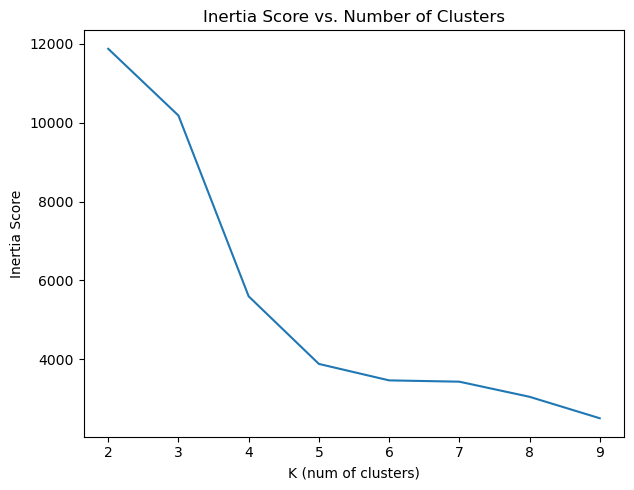

In [56]:
import cuml.cluster
import cuml.metrics
import cudf
import matplotlib.pyplot as plt

# クラスタリング（分割数の検討）
inertias = {}
silhouettes = {}
for k in range(2, 10): 
    km = cuml.cluster.KMeans(n_clusters=k, random_state=1)
    km.fit(rfm_scaled)
    inertias[k] = -km.score(rfm_scaled)
    labels = km.predict(rfm_scaled)
    silhouettes[k] = cuml.metrics.cluster.silhouette_score(rfm_scaled, labels)

# Inertia Scoreのプロット
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
pd.Series(inertias).plot()
plt.xlabel("K (num of clusters)")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")

# シルエットスコアのプロット
print(silhouettes)

plt.tight_layout()
plt.show()


In [57]:
# Using cuml's KMeans implementation
k = 4
km_cuml = cuml.cluster.KMeans(n_clusters=k, random_state=1)
rfm["KMeans"] = km_cuml.fit_predict(rfm_scaled)
rfm.head()

,Frequency,Monetary,Recency,KMeans
0,2,119.06,98,1
1,5,958.84,365,0
2,1,131.90,306,0
3,5,9443.04,319,0
4,13,6638.73,8,1


In [58]:
# DBSCAN
dbscan_cuml = cuml.cluster.DBSCAN(eps=0.5, min_samples=5)
rfm["DBSCAN"] = dbscan_cuml.fit_predict(rfm_scaled)
rfm.head()

,Frequency,Monetary,Recency,KMeans,DBSCAN
0,2,119.06,98,1,0
1,5,958.84,365,0,0
2,1,131.90,306,0,0
3,5,9443.04,319,0,0
4,13,6638.73,8,1,0


In [59]:


import plotly.express as px
import panel as pn

pn.extension('plotly')
rfm = rfm.to_pandas()

fig = px.scatter_3d(rfm, x='Frequency', y='Monetary', z='Recency', color='KMeans')

fig.update_layout(width=1000, height=1000)
pn.panel(fig)

Plotly(Figure)

In [60]:
fig = px.scatter_3d(rfm, x='Frequency', y='Monetary', z='Recency', color='DBSCAN')

fig.update_layout(width=1000, height=1000)
pn.panel(fig)

Plotly(Figure)